In [32]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import os
from natsort import natsorted
import re
from scipy.signal import hilbert
from scipy.signal import convolve
from scipy import stats
from scipy.signal import hann
import seaborn as sns
import matplotlib.pyplot as plt

# Plotly
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)


# %matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]

### Load Data

In [24]:
path = "PHM2019_crack_growth_training_data"

data_dic = {}
labels_dic = {}

for dir1 in natsorted(os.listdir(path)):
    # go over all speciments
    if dir1 not in [".DS_Store",".ipynb_checkpoints"]:
        path1 = os.path.join(path,dir1)
        # get labels
#         print(dir1[-2:])
        df_label = pd.read_excel(os.path.join(path1,'Description_'+dir1[-2:]+'.xlsx'))
        df_label = df_label.iloc[:,:2]
#         print(dir2)
        labels_dic.update({dir1[-2:]:df_label})
        cycles_dic = {}
#         print(path1)
        # go over all cycles
        for dir2 in natsorted(os.listdir(path1)):
#             print(dir2)
            if re.match('\d{5}',dir2):
                path3 = os.path.join(path1,dir2)
#                 print(path3)
                signals = []
                if not (df_label.loc[df_label.iloc[:,0] == float(dir2)].empty):
                    crack_len = df_label.loc[df_label.iloc[:,0] == float(dir2)].iloc[0,-1]
                    # go over all signals
                    for signal in natsorted(os.listdir(path3)):
                        if re.match('signal_.\.csv',signal):
                            signal = os.path.join(path3,signal)
                            df = pd.read_csv(signal)
                            df['label'] = crack_len
                            signals.append(df)
#                     cycles_dic.update({dir2+'_crack_length':crack_len})
                    cycles_dic.update({dir2:signals})
                    data_dic.update({dir1:cycles_dic})

Show the content of data_dictionary

In [25]:
for ik, iv in data_dic.items():
    print('\n',ik, f'Total number of folders inside {len(iv)}')
    for j in  iv.keys():
        print(j, end = '  ')
    print('\n -----------------------------------------------')


 T1 Total number of folders inside 7
50000  60000  62500  65500  69025  70026  70766  
 -----------------------------------------------

 T2 Total number of folders inside 3
50000  70033  72000  
 -----------------------------------------------

 T3 Total number of folders inside 9
14000  50000  57038  60035  62017  64019  65029  66012  66510  
 -----------------------------------------------

 T4 Total number of folders inside 7
55900  60200  65001  70016  71130  73210  75045  
 -----------------------------------------------

 T5 Total number of folders inside 4
42000  46000  51000  56000  
 -----------------------------------------------

 T6 Total number of folders inside 11
40000  50000  70000  73000  77000  79000  82000  85000  88000  91000  93000  
 -----------------------------------------------


In [26]:
data_dic["T1"]["50000"][0].head()

,time,ch1,ch2,label
0,0.000000e+00,0.0,-0.056001,0
1,5.000000e-08,0.0,-0.060001,0
2,1.000000e-07,0.0,-0.056001,0
3,1.500000e-07,0.0,-0.064001,0
4,2.000000e-07,0.0,-0.056001,0


Interpolate  in order to fix missing timestap values

In [27]:
def interpolate_data(data):
    for i, (key,val) in enumerate(data.items()):
        val[0]=val[0].interpolate(method ='linear', limit_direction ='both')
        val[1]=val[1].interpolate(method ='linear', limit_direction ='both')
    return data

for val in data_dic.values():
    val = interpolate_data(val)

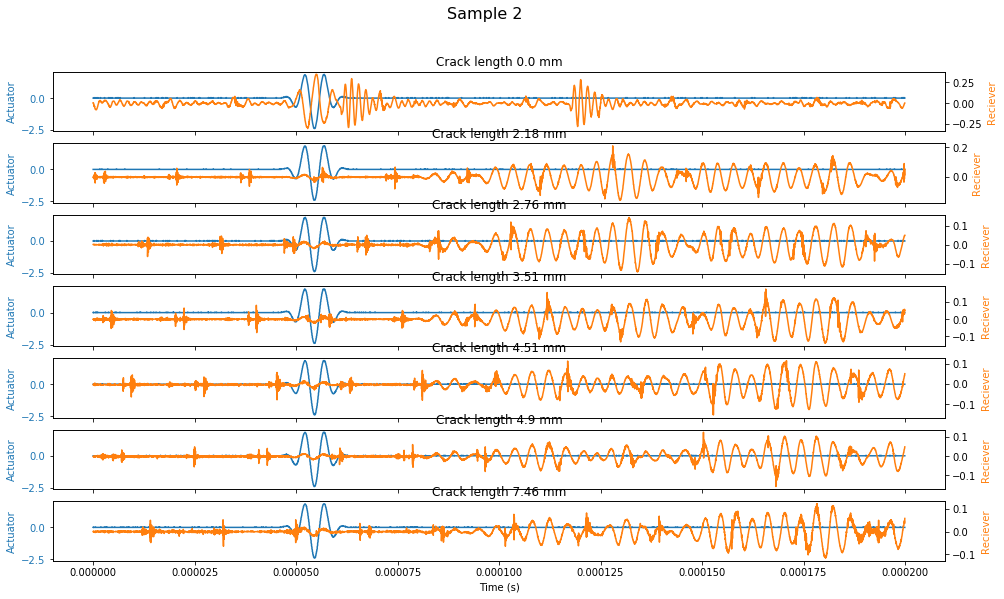

In [46]:
def plot_T0(data, sample = 0):
    
    fig, ax = plt.subplots(len(data),1)
    for i, (key,val) in enumerate(data.items()):
        
        color = "tab:blue"
        if i == len(data)-1:
            ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Actuator", color=color)
        ax[i].plot(val[sample].iloc[:,0],val[sample].iloc[:,1], color=color)
        ax[i].tick_params(axis='y', labelcolor=color)

        ax2 = ax[i].twinx()
        color = "tab:orange"
        ax2.set_ylabel("Reciever", color=color)
        ax2.plot(val[sample].iloc[:,0],val[sample].iloc[:,2], color=color)
        ax[i].title.set_text(f'Crack length {float(np.unique(val[0].iloc[:,-1]))} mm')
        
    fig.suptitle(f'Sample {sample+1}', fontsize=16)
        
    [plt.setp(ax[i].get_xticklabels(), visible=False) for i in range(len(data)-1)]

    
def plot_T(data, sample = 0, size = None):

    len_ = len(data)
    fig = tools.make_subplots(rows=len(data), cols=1,
                              subplot_titles = list(data.keys()),print_grid=False)
    if size == None:
        size = (900, len_*250)
    
    
    for i, (key, val) in enumerate(data.items()):

        trace = go.Scatter(x=val[sample].iloc[:,0], y=val[sample].iloc[:,1], mode='lines', name=f'y{i}',
                           line = dict(color = 'blue'))
        fig.append_trace(trace, i+1, 1)
        trace = go.Scatter(x=val[sample].iloc[:,0], y=val[sample].iloc[:,2], mode='lines', name=f'y{i+len_}',
                           line = dict(color = 'red'))
        fig.append_trace(trace, i+1, 1)
    
    t = len_
    for i in range(t*2):
        if i%2==1:
            t+=1
            fig['data'][i].update(yaxis=f'y{t}')


    fig['layout'].update(autosize=False, width=size[0], height=size[1], showlegend=False, hovermode='x')


    for i in range(len_):
        fig['layout'][f'yaxis{i+1}'].update(showgrid=False, title='Actuator', color = 'blue')
        fig['layout'][f'yaxis{i+len_+1}'] = dict(overlaying=f'y{i+1}', anchor=f'x{i+1}', 
                                                   side='right', showgrid=False, title='Reciever', color = 'red')
        fig['layout']['annotations'][i]["text"] = f'Number of cycles {list(data.keys())[i]}'
        
    return py.iplot(fig, filename='simple-subplot-with-annotations', template='ggplot')


T = "T1"
plot_T = plot_T0
# plot_T(data_dic[T])
plot_T(data_dic[T], sample = 1)

### FFT data

In [19]:
fft_data = {}

def fft_(data, crop_pandas = True, normalize = True):
    output = {}
    for i, (key, val) in enumerate(data.items()):
        fft_signal1 = pd.DataFrame()
        fft_signal2 = pd.DataFrame()
        fft_signal1['Frequency'] = np.split(np.fft.fftfreq(len(val[0]), d=1/2e7),2)[0]
        fft_signal2['Frequency'] = np.split(np.fft.fftfreq(len(val[0]), d=1/2e7),2)[0]

        for j in range(2):
#             print(len(np.fft.fftfreq(len(val[0]), d=2e7)))
#             print(len(val[0]))
            fft_signal1[f"ch{j}"] = np.split(np.abs(np.fft.fft(val[0].iloc[:,j+1])),2)[0]
            fft_signal2[f"ch{j}"] = np.split(np.abs(np.fft.fft(val[1].iloc[:,j+1])),2)[0]
            
            if normalize:
                fft_signal1[f"ch{j}"] = fft_signal1[f"ch{j}"]/np.max(fft_signal1[f"ch{j}"])
                fft_signal2[f"ch{j}"] = fft_signal2[f"ch{j}"]/np.max(fft_signal2[f"ch{j}"])
            
        fft_signal1["label"] = float(np.unique(val[0].iloc[:,-1]))
        fft_signal2["label"] = float(np.unique(val[1].iloc[:,-1]))
                
        if crop_pandas:
            output.update({key:[fft_signal1.iloc[10:,:], fft_signal2.iloc[10:,:]]})
        else:
            output.update({key:[fft_signal1, fft_signal2]})

    return output
    
for key, val in data_dic.items():
    fft_data.update({key:fft_(val)})

In [20]:
fft_data["T1"]["70026"][0].head()

,Frequency,ch0,ch1,label
10,50000.0,0.008056,0.025271,4.9
11,55000.0,0.009337,0.023049,4.9
12,60000.0,0.006467,0.023501,4.9
13,65000.0,0.008686,0.022349,4.9
14,70000.0,0.016722,0.025084,4.9


In [21]:
T = "T5"
plot_T(fft_data[T])
plot_T(fft_data[T], sample = 1)

Feature engineering

In [ ]:
def create_features(data, demo = True):
    
    created = {}
    
    for key, val in data.items():
        Xs = []
        for v in val:
            
            xc = v.iloc[:,2]
            X = pd.DataFrame()
            
            if demo:
        
                X['mean'] = np.array([xc.mean()])
                X['std'] = np.array([xc.std()])
                X['mean_change_abs'] = np.array([np.mean(np.diff(xc))])
                X['mean_change_rate'] = np.array([np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])])
                X['abs_max'] = np.array([np.abs(xc).max()])
                X['abs_min'] = np.array([np.abs(xc).min()])


                for windows in [10, 100, 1000]:
                    x_roll_std = xc.rolling(windows).std().dropna().values
                    x_roll_mean = xc.rolling(windows).mean().dropna().values

                    X['ave_roll_std_' + str(windows)] = np.array([x_roll_std.mean()])
                    X['std_roll_std_' + str(windows)] = np.array([x_roll_std.std()])
                    X['max_roll_std_' + str(windows)] = np.array([x_roll_std.max()])
                    X['min_roll_std_' + str(windows)] = np.array([x_roll_std.min()])
                    
                    
                    
            else: 
                X['mean'] = np.array([xc.mean()])
                X['std'] = np.array([xc.std()])
                X['max'] = np.array([xc.max()])
                X['min'] = np.array([xc.min()])

                X['mean_change_abs'] = np.array([np.mean(np.diff(xc))])
                X['mean_change_rate'] = np.array([np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])])
                X['abs_max'] = np.array([np.abs(xc).max()])
                X['abs_min'] = np.array([np.abs(xc).min()])

                X['std_first_50000'] = np.array([xc[:50000].std()])
                X['std_last_50000'] = np.array([xc[-50000:].std()])
                X['std_first_10000'] = np.array([xc[:10000].std()])
                X['std_last_10000'] = np.array([xc[-10000:].std()])

                X['avg_first_50000'] = np.array([xc[:50000].mean()])
                X['avg_last_50000'] = np.array([xc[-50000:].mean()])
                X['avg_first_10000'] = np.array([xc[:10000].mean()])
                X['avg_last_10000'] = np.array([xc[-10000:].mean()])

                X['min_first_50000'] = np.array([xc[:50000].min()])
                X['min_last_50000'] = np.array([xc[-50000:].min()])
                X['min_first_10000'] = np.array([xc[:10000].min()])
                X['min_last_10000'] = np.array([xc[-10000:].min()])

                X['max_first_50000'] = np.array([xc[:50000].max()])
                X['max_last_50000'] = np.array([xc[-50000:].max()])
                X['max_first_10000'] = np.array([xc[:10000].max()])
                X['max_last_10000'] = np.array([xc[-10000:].max()])

                X['max_to_min'] = np.array([xc.max() / np.abs(xc.min())])
                X['max_to_min_diff'] = np.array([xc.max() - np.abs(xc.min())])
                X['count_big'] = np.array([len(xc[np.abs(xc) > 500])])
                X['sum'] = np.array([xc.sum()])

                X['mean_change_rate_first_50000'] = np.array([np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])])
                X['mean_change_rate_last_50000'] = np.array([np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])])
                X['mean_change_rate_first_10000'] = np.array([np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])])
                X['mean_change_rate_last_10000'] = np.array([np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])])

                X['q95'] = np.array([np.quantile(xc, 0.95)])
                X['q99'] = np.array([np.quantile(xc, 0.99)])
                X['q05'] = np.array([np.quantile(xc, 0.05)])
                X['q01'] = np.array([np.quantile(xc, 0.01)])

                X['abs_q95'] = np.array([np.quantile(np.abs(xc), 0.95)])
                X['abs_q99'] = np.array([np.quantile(np.abs(xc), 0.99)])
                X['abs_q05'] = np.array([np.quantile(np.abs(xc), 0.05)])
                X['abs_q01'] = np.array([np.quantile(np.abs(xc), 0.01)])

                X['abs_mean'] = np.array([np.abs(xc).mean()])
                X['abs_std'] = np.array([np.abs(xc).std()])

                X['mad'] = np.array([xc.mad()])
                X['kurt'] = np.array([xc.kurtosis()])
                X['skew'] = np.array([xc.skew()])
                X['med'] = np.array([xc.median()])

                X['Hilbert_mean'] = np.array([np.abs(hilbert(xc)).mean()])
                X['Hann_window_mean'] = np.array([(convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()])
                X['Moving_average_700_mean'] = np.array([xc.rolling(window=700).mean().mean(skipna=True)])
                X['Moving_average_1500_mean'] = np.array([xc.rolling(window=1500).mean().mean(skipna=True)])
                X['Moving_average_3000_mean'] = np.array([xc.rolling(window=3000).mean().mean(skipna=True)])
                X['Moving_average_6000_mean'] = np.array([xc.rolling(window=6000).mean().mean(skipna=True)])
                ewma = pd.Series.ewm
                X['exp_Moving_average_300_mean'] = np.array([(ewma(xc, span=300).mean()).mean(skipna=True)])
                X['exp_Moving_average_3000_mean'] = np.array([ewma(xc, span=3000).mean().mean(skipna=True)])
                X['exp_Moving_average_30000_mean'] = np.array([ewma(xc, span=6000).mean().mean(skipna=True)])
                no_of_std = 2
                X['MA_700MA_std_mean'] = np.array([xc.rolling(window=700).std().mean()])
                X['MA_700MA_BB_high_mean'] = np.array([(X['Moving_average_700_mean'] + no_of_std * X['MA_700MA_std_mean']).mean()])
                X['MA_700MA_BB_low_mean'] = np.array([(X['Moving_average_700_mean'] - no_of_std * X['MA_700MA_std_mean']).mean()])
                X['MA_400MA_std_mean'] = np.array([xc.rolling(window=400).std().mean()])
                X['MA_400MA_BB_high_mean'] = np.array([(X['Moving_average_700_mean'] + no_of_std * X['MA_400MA_std_mean']).mean()])
                X['MA_400MA_BB_low_mean'] = np.array([(X['Moving_average_700_mean'] - no_of_std * X['MA_400MA_std_mean']).mean()])
                X['MA_1000MA_std_mean'] = np.array([xc.rolling(window=1000).std().mean()])

                X['iqr'] = np.array([np.subtract(*np.percentile(xc, [75, 25]))])
                X['q999'] = np.array([np.quantile(xc,0.999)])
                X['q001'] = np.array([np.quantile(xc,0.001)])
                X['ave10'] = np.array([stats.trim_mean(xc, 0.1)])

                for windows in [10, 100, 1000]:
                    x_roll_std = xc.rolling(windows).std().dropna().values
                    x_roll_mean = xc.rolling(windows).mean().dropna().values

                    X['ave_roll_std_' + str(windows)] = np.array([x_roll_std.mean()])
                    X['std_roll_std_' + str(windows)] = np.array([x_roll_std.std()])
                    X['max_roll_std_' + str(windows)] = np.array([x_roll_std.max()])
                    X['min_roll_std_' + str(windows)] = np.array([x_roll_std.min()])
                    X['q01_roll_std_' + str(windows)] = np.array([np.quantile(x_roll_std, 0.01)])
                    X['q05_roll_std_' + str(windows)] = np.array([np.quantile(x_roll_std, 0.05)])
                    X['q95_roll_std_' + str(windows)] = np.array([np.quantile(x_roll_std, 0.95)])
                    X['q99_roll_std_' + str(windows)] = np.array([np.quantile(x_roll_std, 0.99)])
                    X['av_change_abs_roll_std_' + str(windows)] = np.array([np.mean(np.diff(x_roll_std))])
                    X['av_change_rate_roll_std_' + str(windows)] = np.array([np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])])
                    X['abs_max_roll_std_' + str(windows)] = np.array([np.abs(x_roll_std).max()])

                    X['ave_roll_mean_' + str(windows)] = np.array([x_roll_mean.mean()])
                    X['std_roll_mean_' + str(windows)] = np.array([x_roll_mean.std()])
                    X['max_roll_mean_' + str(windows)] = np.array([x_roll_mean.max()])
                    X['min_roll_mean_' + str(windows)] = np.array([x_roll_mean.min()])
                    X['q01_roll_mean_' + str(windows)] = np.array([np.quantile(x_roll_mean, 0.01)])
                    X['q05_roll_mean_' + str(windows)] = np.array([np.quantile(x_roll_mean, 0.05)])
                    X['q95_roll_mean_' + str(windows)] = np.array([np.quantile(x_roll_mean, 0.95)])
                    X['q99_roll_mean_' + str(windows)] = np.array([np.quantile(x_roll_mean, 0.99)])
                    X['av_change_abs_roll_mean_' + str(windows)] = np.array([np.mean(np.diff(x_roll_mean))])
                    X['av_change_rate_roll_mean_' + str(windows)] = np.array([np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])])
                    X['abs_max_roll_mean_' + str(windows)] = np.array([np.abs(x_roll_mean).max()])

            X['label'] = float(np.unique(v.iloc[:,-1]))
            Xs.append(X)
        created.update({key:Xs})
    return created
            

data_feature = {}
for key, val in data_dic.items():
    data_feature.update({key:create_features(val, demo = False)})

In [ ]:
X_data = pd.DataFrame(columns=data_feature["T5"]["56000"][0].columns)
X = []

for key, val in data_feature.items():
    for key2, val2 in val.items():
        for ii, i in enumerate(val2):
            i["name"] = key + " " + key2 + " signal" + str(ii)
            X.append(i)
X_data = pd.concat(X,ignore_index=True)
X_data = X_data.set_index("name")

In [ ]:
X_data[X_data.index.str.contains('T4')]

In [ ]:
sns.heatmap(X_data.corr().iloc[:-1,-1:])
# print(X_data.corr().iloc[:,-1:])
print(np.max(np.abs(X_data.corr().iloc[:-1,-1:])))

In [ ]:
sns.heatmap(X_data.corr())